In [13]:
import pandas as pd
from pyhandy import get_data_summary
calidad_aire_df = (
    pd.read_feather('01-data/processed/aq_ayto_madrid-sin-imputar.feather')
     .set_index(['fecha','estacion','variable'])['value']
     .unstack()
     .sort_values('fecha')
     .reset_index()
     .rename_axis(columns=[''])
)
get_data_summary(calidad_aire_df)

Dataset has 1695071 rows and 16 columns


,DataType,MissingPercent,Mean,Median,Mode,MinValue,MaxValue,NumOfUnique,UniqueValues,FracUnique
ColumnName,,,,,,,,,,
fecha,datetime64[ns],0.000000,NaN,NaN,NaN,2013-07-01 01:00:00,2021-07-31 23:00:00,70871,NaN,NaN
ben_µg_m3,float64,0.755779,0.517102,0.30,0.1,0.0,10.7,194,NaN,NaN
ch4_mg_m3,float64,0.885591,1.243671,1.23,1.18,0.0,4.33,325,NaN,NaN
co_mg_m3,float64,0.610086,0.318721,0.30,0.2,0.0,1.4,43,NaN,NaN
ebe_µg_m3,float64,0.754805,0.455669,0.20,0.1,0.0,23.9,257,NaN,NaN
nmhc_mg_m3,float64,0.886643,0.146281,0.12,0.08,0.0,0.79,126,NaN,NaN
no2_µg_m3,float64,0.025664,33.271683,27.00,10.0,0.0,185.0,209,NaN,NaN
no_µg_m3,float64,0.026612,13.965494,4.00,1.0,0.0,799.0,479,NaN,NaN
nox_µg_m3,float64,0.030034,54.054100,34.00,12.0,0.0,452.0,476,NaN,NaN


In [14]:
indicators_abbrev_dict = {
    'Dióxido de Azufre':'SO2','Monóxido de Carbono':'CO', 'Monóxido de Nitrógeno':'NO',
    'Dióxido de Nitrógeno':'NO2','Partículas < 2.5 µm':'PM2.5','Partículas < 10 µm':'PM10',
    'Óxidos de Nitrógeno':'NOx','Ozono':'O3','Tolueno':'TOL','Benceno':'BEN',
    'Etilbenceno':'EBE','Metaxileno':'MXY','Paraxileno':'PXY','Ortoxileno':'OXY',
    'Hidrocarburos totales':'TCH','Metano':'CH4','Hidrocarburos no metánicos':'NMHC'
}
indicators_abbrev_dict_rev = {v:k for k,v in indicators_abbrev_dict.items()}

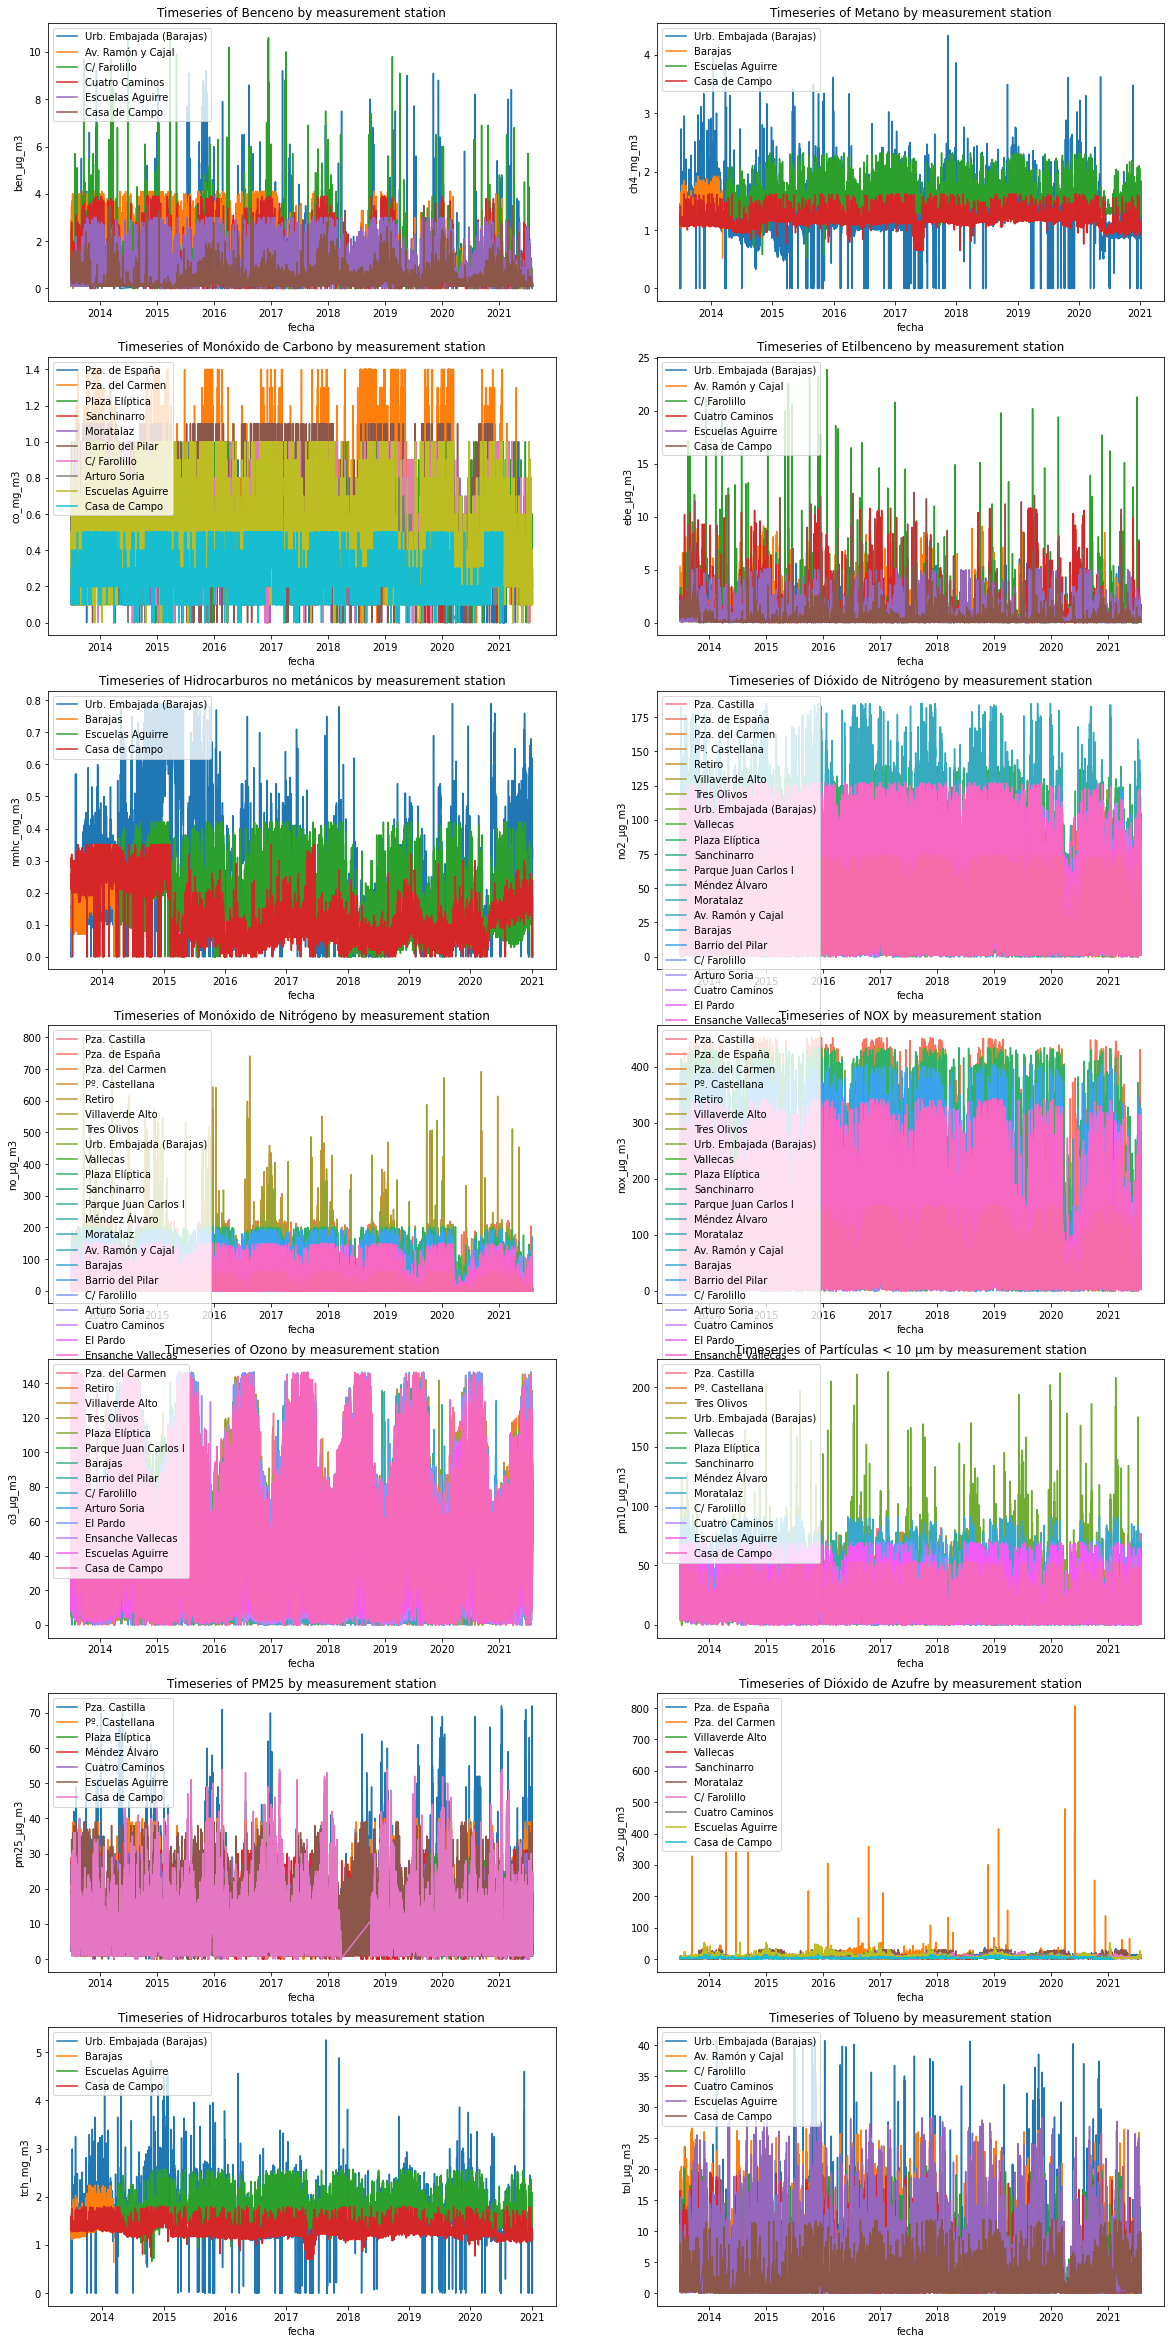

In [31]:
# Visualizar las series de tiempo de cada indicador por cada estacion
from scipy import stats
import numpy as np
from pyhandy import subplotted
import seaborn as sns

df = calidad_aire_df[calidad_aire_df.fecha>'2013-07-01']
indicators_data_list = []
for fig,ax,indicator in subplotted(df.columns.drop(['fecha','estacion'])):
    #Get indicator data
    indicator_df = df[['fecha','estacion',indicator]]
    estaciones_data_list = []
    for estacion in indicator_df.estacion.unique():
        estacion_df = indicator_df[indicator_df.estacion==estacion].copy()
        if len(estacion_df.dropna())==0:
            continue #La estacion no soporta este indicador
        #Interpolate up to 6 consecutive missing values
        estacion_df[estacion_df.columns.drop(['fecha','estacion'])] = estacion_df[
            estacion_df.columns.drop(['fecha','estacion'])
        ].interpolate(limit=6)
        #drop columns with all nans and then drop rows with any nans
        estacion_df = estacion_df.dropna(how='all',axis=1).dropna()
        indicator_columns = estacion_df.columns.drop(['fecha','estacion'])
        #Remove Outliers
        outliers = (np.abs(stats.zscore(estacion_df[indicator_columns])) < 2.5).all(axis=1)
        estacion_df = estacion_df[outliers]
        estaciones_data_list.append(estacion_df)
        #Add to the plot
    estaciones_data = pd.concat(estaciones_data_list)
    sns.lineplot(data=estaciones_data,x='fecha',y=indicator,ax=ax,hue='estacion')
    ax.legend(loc='upper left')
    indicator_name=indicator.split('_')[0].upper()
    ax.set_title('Timeseries of ' + indicators_abbrev_dict_rev.get(indicator_name,indicator_name) +' by measurement station')
    indicators_data_list.append(estaciones_data)
# fig.tight_layout()

In [7]:
[col for col in df.columns if col.split("_")[0] in relevant_indicators]

['co_mg_m3', 'no2_µg_m3', 'nox_µg_m3', 'pm10_µg_m3', 'pm25_µg_m3']

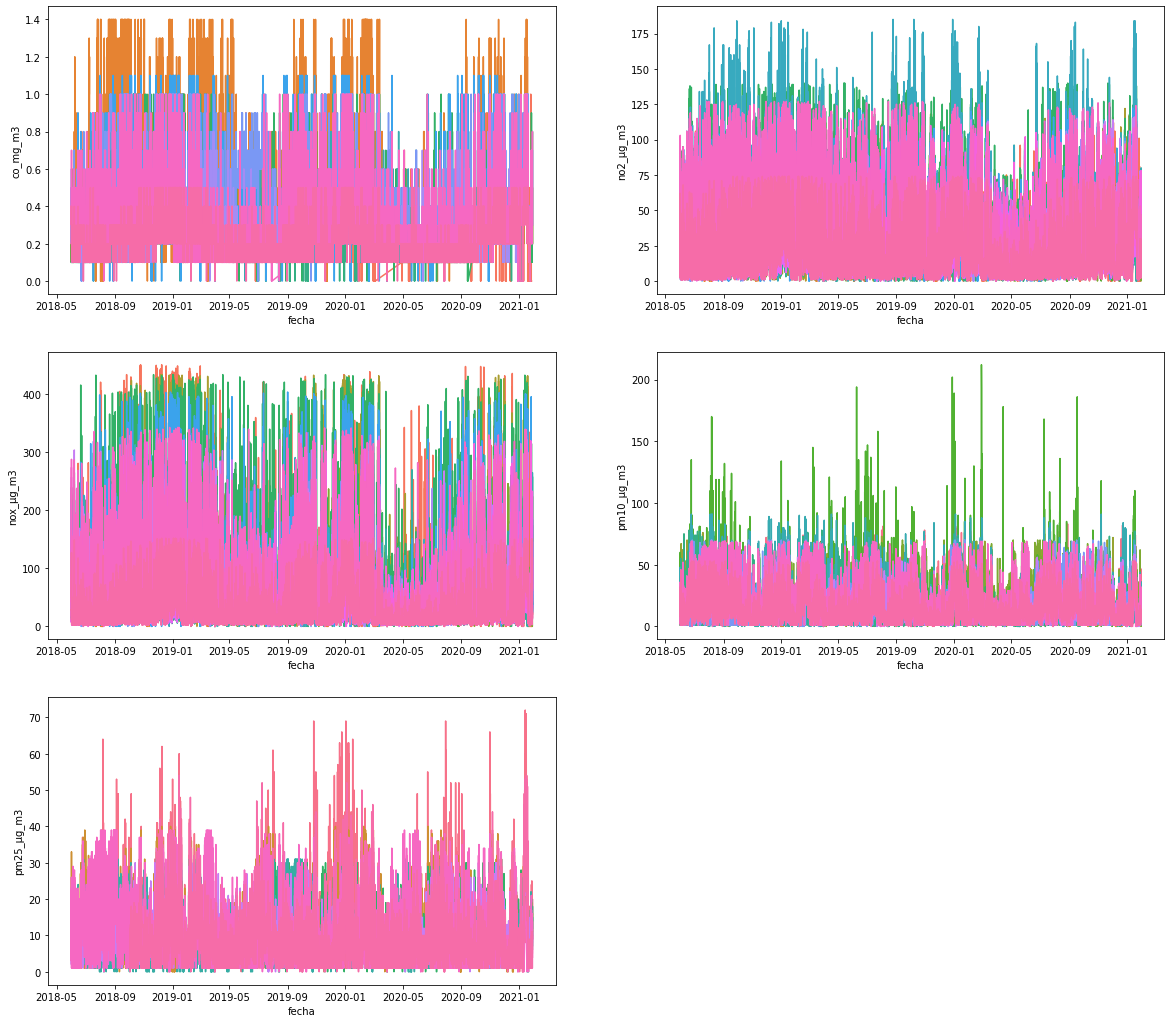

In [17]:
import seaborn as sns
from pyhandy import subplotted
relevant_indicators = ["co","co2", "no2","nox","pm25","pm10","o3"]

start = "2018-06-01"
end = "2021-03-30"
#Filomena
df = calidad_aire_df[(calidad_aire_df.fecha>start)&(calidad_aire_df.fecha<end)]
pol_cols = [col for col in df.columns if col.split("_")[0] in relevant_indicators]
for fig,ax,col in subplotted(pol_cols):
    sns.lineplot(data=df,x='fecha',y=col,hue='estacion',ax=ax)
    ax.get_legend().remove()

In [2]:
# Visualizar las series de tiempo de cada indicador por cada estacion
from scipy import stats
import numpy as np
from pyhandy import subplotted
import seaborn as sns

df = calidad_aire_df[calidad_aire_df.fecha>'2013-07-01']
indicators_data_list = []
for indicator in (df.columns.drop(['fecha','estacion'])):
    #Get indicator data
    indicator_df = df[['fecha','estacion',indicator]]
    estaciones_data_list = []
    for estacion in indicator_df.estacion.unique():
        estacion_df = indicator_df[indicator_df.estacion==estacion].copy()
        if len(estacion_df.dropna())==0:
            continue #La estacion no soporta este indicador
        #Interpolate up to 6 consecutive missing values
        estacion_df[estacion_df.columns.drop(['fecha','estacion'])] = estacion_df[
            estacion_df.columns.drop(['fecha','estacion'])
        ].interpolate(limit=6)
        #drop columns with all nans and then drop rows with any nans
        estacion_df = estacion_df.dropna(how='all',axis=1).dropna()
        indicator_columns = estacion_df.columns.drop(['fecha','estacion'])
        #Remove Outliers
        outliers = (np.abs(stats.zscore(estacion_df[indicator_columns])) < 2.5).all(axis=1)
        estacion_df = estacion_df[outliers]
        estaciones_data_list.append(estacion_df)
        #Add to the plot
    estaciones_data = pd.concat(estaciones_data_list)
#     sns.lineplot(data=estaciones_data,x='fecha',y=indicator,ax=ax,hue='estacion')
#     ax.legend(loc='upper left')
    indicator_name=indicator.split('_')[0].upper()
#     ax.set_title('Timeseries of ' + indicators_abbrev_dict_rev.get(indicator_name,indicator_name) +' by measurement station')
    indicators_data_list.append(estaciones_data)
# fig.tight_layout()

In [3]:
df_imputado = pd.DataFrame(index=calidad_aire_df.index,columns=calidad_aire_df.columns).astype(calidad_aire_df.dtypes)
for df in indicators_data_list:
    df_imputado.loc[df.index,df.columns] = df.copy()
df_imputado = df_imputado.dropna(how='all',axis=0)

In [8]:
(df_imputado
 .melt(id_vars=['fecha','estacion'],var_name='variable')
 .dropna(subset=['value'])
 .reset_index(drop=True)
 .to_feather('01-data/aq_ayto_madrid-sin-imputar.feather')
)

In [5]:
pd.read_feather('01-data/aq_ayto_madrid-sin-imputar-2013.feather')

,fecha,estacion,variable,value
0,2013-01-01 00:00:00,Urb. Embajada (Barajas),ben_µg_m3,1.8
1,2013-01-01 00:00:00,Cuatro Caminos,ben_µg_m3,1.4
2,2013-01-01 00:00:00,Escuelas Aguirre,ben_µg_m3,1.8
3,2013-01-01 00:00:00,Av. Ramón y Cajal,ben_µg_m3,3.7
4,2013-01-01 00:00:00,Casa de Campo,ben_µg_m3,0.9
...,...,...,...,...
11228803,2021-07-31 23:00:00,C/ Farolillo,tol_µg_m3,0.4
11228804,2021-07-31 23:00:00,Casa de Campo,tol_µg_m3,0.1
11228805,2021-07-31 23:00:00,Av. Ramón y Cajal,tol_µg_m3,0.1
11228806,2021-07-31 23:00:00,Escuelas Aguirre,tol_µg_m3,0.6


In [4]:
get_data_summary(df_imputado)

Dataset has 1695071 rows and 16 columns


,DataType,MissingPercent,Mean,Median,Mode,MinValue,MaxValue,NumOfUnique,UniqueValues,FracUnique
ColumnName,,,,,,,,,,
fecha,datetime64[ns],0.000000,NaN,NaN,NaN,2013-07-01 01:00:00,2021-07-31 23:00:00,70871,NaN,NaN
ben_µg_m3,float64,0.755779,0.517102,0.30,0.1,0.0,10.7,194,NaN,NaN
ch4_mg_m3,float64,0.885591,1.243671,1.23,1.18,0.0,4.33,325,NaN,NaN
co_mg_m3,float64,0.610086,0.318721,0.30,0.2,0.0,1.4,43,NaN,NaN
ebe_µg_m3,float64,0.754805,0.455669,0.20,0.1,0.0,23.9,257,NaN,NaN
nmhc_mg_m3,float64,0.886643,0.146281,0.12,0.08,0.0,0.79,126,NaN,NaN
no2_µg_m3,float64,0.025664,33.271683,27.00,10.0,0.0,185.0,209,NaN,NaN
no_µg_m3,float64,0.026612,13.965494,4.00,1.0,0.0,799.0,479,NaN,NaN
nox_µg_m3,float64,0.030034,54.054100,34.00,12.0,0.0,452.0,476,NaN,NaN
